<a href="https://colab.research.google.com/github/vkth7/AIFFEL-exploration/blob/main/exp-05/%5Bexp_05%5D%EA%B0%80%EC%9C%84%EB%B0%94%EC%9C%84%EB%B3%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import

In [ ]:
import tensorflow as tf
import numpy as np

from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
from tensorflow import keras

from sklearn.model_selection import train_test_split

import random

## image를 28X28로 변경

In [ ]:
def resize_images(img_path):
	images=glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = '/content/drive/MyDrive/ColabNotebooks/rock_scissor_paper'
resize_images(image_dir_path+'/scissor')
print("가위 이미지 resize 완료!")
resize_images(image_dir_path+'/rock')
print("바위 이미지 resize 완료!")
resize_images(image_dir_path+'/paper')
print("보 이미지 resize 완료!")

913  images to be resized.
913  images resized.
가위 이미지 resize 완료!
913  images to be resized.
913  images resized.
바위 이미지 resize 완료!
913  images to be resized.
913  images resized.
보 이미지 resize 완료!


## 변환한 image 파일 불러오기

In [ ]:
def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels


In [ ]:
image_dir_path = '/content/drive/MyDrive/ColabNotebooks/rock_scissor_paper'
(X, y)=load_data(image_dir_path, number_of_data=913*3)
X_norm = X/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(X.shape))
print("y_train shape: {}".format(y.shape))

학습데이터(x_train)의 이미지 개수는 2739 입니다.
x_train shape: (2739, 28, 28, 3)
y_train shape: (2739,)


라벨:  0


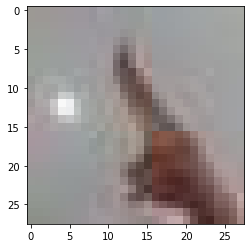

In [ ]:
plt.imshow(X[0])
print('라벨: ', y[0])

## 불러온 파일을 train, test 데이터셋으로 나누기

In [ ]:
X_train, X_test, y_train, y_test = X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2,random_state=2022)

In [ ]:
X_train.shape

(2191, 28, 28, 3)

## Conv2D 레이어를 2개, MaxPooling을 2회 진행하고 Dense 레이어를 1번, 마지막으로 Output 레이어로 출력한다.

In [ ]:
n_channel_1=64
n_channel_2=128
n_dense=128
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3200)              0         
                                                                 
 dense (Dense)               (None, 128)               4

## 먼저 test 셋으로 나눈 이미지로 학습한 모델을 평가한다.

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

18/18 - 0s - loss: 0.0626 - accuracy: 0.9745 - 190ms/epoch - 11ms/step
test_loss: 0.06257978826761246 
test_accuracy: 0.974452555179596


## 새로운 이미지 파일을 28X28로 변환

In [ ]:
image_dir_path = '/content/drive/MyDrive/ColabNotebooks/rock_scissor_paper/test'
resize_images(image_dir_path+'/scissor')
print("가위 이미지 resize 완료!")
resize_images(image_dir_path+'/rock')
print("바위 이미지 resize 완료!")
resize_images(image_dir_path+'/paper')
print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!
100  images to be resized.
100  images resized.
바위 이미지 resize 완료!
100  images to be resized.
100  images resized.
보 이미지 resize 완료!


## test 데이터셋으로 불러오기

In [ ]:
image_dir_path = '/content/drive/MyDrive/ColabNotebooks/rock_scissor_paper/test'
(X_test2, y_test2)=load_data(image_dir_path, number_of_data=100*3)
X_norm2 = X_test2/255.0

학습데이터(x_train)의 이미지 개수는 300 입니다.


## 불러온 데이터셋으로 학습한 모델 평가

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test2, y_test2, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 408.5832 - accuracy: 0.5167 - 143ms/epoch - 14ms/step
test_loss: 408.5831604003906 
test_accuracy: 0.5166666507720947


In [ ]:
predicted_result = model.predict(X_test2)  # model이 추론한 확률값. 
predicted_labels = np.argmax(predicted_result, axis=1)

idx=0  #1번째 x_test를 살펴보자. 
print('model.predict() 결과 : ', predicted_result[idx])
print('model이 추론한 가장 가능성이 높은 결과 : ', predicted_labels[idx])
print('실제 데이터의 라벨 : ', y_test2[idx])

model.predict() 결과 :  [0.00354714 0.         0.9964529 ]
model이 추론한 가장 가능성이 높은 결과 :  2
실제 데이터의 라벨 :  0


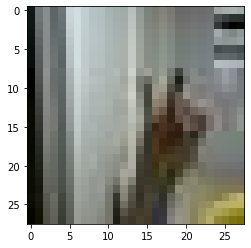

예측확률분포: [0. 0. 1.]
라벨: 1, 예측결과: 2


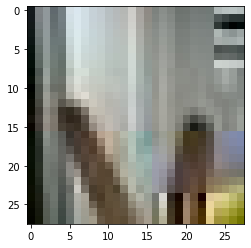

예측확률분포: [1. 0. 0.]
라벨: 1, 예측결과: 0


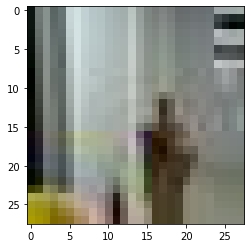

예측확률분포: [0.0000000e+00 1.0000000e+00 1.6240591e-29]
라벨: 0, 예측결과: 1


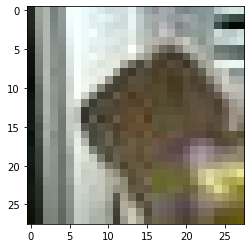

예측확률분포: [0. 0. 1.]
라벨: 0, 예측결과: 2


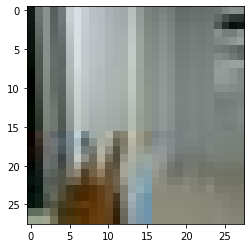

예측확률분포: [0. 0. 1.]
라벨: 1, 예측결과: 2


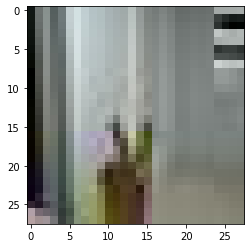

In [ ]:
plt.imshow(X_test2[idx],cmap=plt.cm.binary)
plt.show()

wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모아 봅시다. 
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑아봅시다.
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(X_test2[n], cmap=plt.cm.binary)
    plt.show()

In [ ]:
n_channel_1=32
n_channel_2=64
n_dense=256
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

18/18 - 0s - loss: 0.0732 - accuracy: 0.9763 - 162ms/epoch - 9ms/step
test_loss: 0.0731654167175293 
test_accuracy: 0.9762773513793945


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test2, y_test2, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 503.9284 - accuracy: 0.5933 - 140ms/epoch - 14ms/step
test_loss: 503.9283752441406 
test_accuracy: 0.5933333039283752


In [ ]:
n_channel_1=16
n_channel_2=32
n_dense=128
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(X_train, y_train, epochs=n_train_epoch)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 800)               0         
                                                                 
 dense_12 (Dense)            (None, 128)              

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test2, y_test2, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 658.1330 - accuracy: 0.4533 - 138ms/epoch - 14ms/step
test_loss: 658.1329956054688 
test_accuracy: 0.4533333480358124


In [ ]:
n_channel_1=16
n_channel_2=32
n_dense=128
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(X_train, y_train, epochs=n_train_epoch)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 flatten_7 (Flatten)         (None, 800)               0         
                                                                 
 dense_14 (Dense)            (None, 128)              

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test2, y_test2, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 989.4568 - accuracy: 0.5133 - 140ms/epoch - 14ms/step
test_loss: 989.4568481445312 
test_accuracy: 0.5133333206176758


In [ ]:
n_channel_1=16
n_channel_2=32
n_dense=64
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(X_train, y_train, epochs=n_train_epoch)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 13, 13, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 11, 11, 32)        4640      
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 5, 5, 32)         0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 800)               0         
                                                                 
 dense_16 (Dense)            (None, 64)               

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test2, y_test2, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 307.0628 - accuracy: 0.6200 - 163ms/epoch - 16ms/step
test_loss: 307.06280517578125 
test_accuracy: 0.6200000047683716


# 회고

## 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 한 데이터 셋에서 train, test 데이터셋으로 나눈 경우 비슷한 image 데이터가 많이 있어 90%대의 정확도를 지니지만 완전히 다른 데이터셋을 테스트 셋으로 했을 경우 40~50%의 정확도만 지닌 것을 확인했다.
- 이 경우 overfitting이 돼서 그런 것으로 예상된다.

## 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- overfitting이 된 것으로 예상되어 channel_1, channel_2, dense를 줄여가며 다시 학습 시켜보았다.
- 순서대로 16, 32, 64에서 accuracy가 60%를 넘는 것을 확인하였다.